In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime
from pygam import LinearGAM, s, f
import statsmodels.api as sm


In [7]:
#On réalise un lissage exponentielle sur la température de paramètre alpha
def exponential_smooth(T_K, alpha):
    t_smooth = [T_K[0]]
    for i in range(1, len(T_K)):
        t_smooth.append(alpha * T_K[i] + (1 - alpha) * t_smooth[i - 1])
    return t_smooth

# Fonction pour marquer les dates de confinement
def debut_covid(X):
    start_covid_date = datetime.strptime('20200301', '%Y%m%d') #On initialise la date du covid en tant qu'objet datetime
    dates = pd.to_datetime(X['Date'], format='%Y%m%d') # Convertit la colonne 'Date' en objets datetime
    return [1 if date >= start_covid_date else 0 for date in dates] #on renvoie donc ce qui nous intéresse : une liste avec des 0 si la date est postérieur au covid et 1 sinon

# Fonction pour marquer les dates de sobriété énergétique
def sobriété(X):
    start_sobriété_date = datetime.strptime('20221001', '%Y%m%d') #On initialise la date du covid en tant qu'objet datetime
    dates = pd.to_datetime(X['Date'], format='%Y%m%d')# Convertit la colonne 'Date' en objets datetime
    return [1 if date >= start_sobriété_date else 0 for date in dates] #On renvoie donc ce qui nous intéresse : une liste avec des 0 si la date est postérieur à la sobriété et 1 sinon

#On réalise un smoothing de la température plus intéressant 
def loess_smoothing(data, frac=0.1):
    loess = sm.nonparametric.lowess(data, np.arange(len(data)), frac=frac) #On réalise un loess smoothing 
    return loess[:, 1]


In [8]:
# Chargement des données
path = r'data' #J'ai mis le chemin vers les données de test/train/sample_submission, changez ce paramètre avec l'endroit ou vous avez mis les données
df_sample = pd.read_csv(os.path.join(path, 'sample_submission.csv'))
df_train = pd.read_csv(os.path.join(path, 'train.csv'))
df_test = pd.read_csv(os.path.join(path, 'test.csv'))

# Préparation des données
X_train = df_train[(df_train['year'] > 2020)].copy() #On sélectionne uniquement les années 2021-2022 dans le jeu de test
X_test = df_test.copy()

#y_train_X contient les valeurs associé au données d'entrainement de la variable X
y_train_load = X_train['Load'].to_numpy() 
y_train_solar = X_train['Solar_power'].to_numpy() 
y_train_wind = X_train['Wind_power'].to_numpy()

# Ajout des nouvelles caractéristiques
X_combined = pd.concat([X_train, X_test], axis=0) #On fait la combinaison de X_train et X_test afin d'avoir les années de 2021 à 2023 de manière continue pour les smoothing

X_combined['temperature_smooth'] = exponential_smooth(X_combined['temperature'].to_numpy(),0.95) #On réalise un smoothing faible de la température
X_combined['temperature_smooth_fort'] = exponential_smooth(X_combined['temperature'].to_numpy(),0.05) #On réalise un smoothing fort de la température

X_combined['Covid'] = debut_covid(X_combined) #On rajoute une variable 'Covid' qui se met à 1 dès que le covid a commencé et 0 sinon
X_combined['Sobriete'] = sobriété(X_combined) #On rajoute une variable 'Sobriete' qui se met à 1 dès que la sobriété a commencé et 0 sinon

X_combined['temperature_loess'] = loess_smoothing(X_combined['temperature'], frac=0.1) #On réalise un smoothing très lisse

X_combined['temp_lag1'] = X_combined['temperature'].shift(24) #Température décalée de une demi journée
X_combined['temp_lag2'] = X_combined['temperature'].shift(48) #température décalée de une journée

fill_values_temp_lag1 = df_train['temperature'].iloc[:24].to_numpy() #On prend les température d'avant pour remplir les valeurs 'Na' du au décalage
fill_values_temp_lag2 = df_train['temperature'].iloc[:48].to_numpy() #On prend les température d'avant pour remplir les valeurs 'Na' du au décalage

# Remplir les NaN
X_combined['temp_lag1'] = X_combined['temp_lag1'].fillna(pd.Series(fill_values_temp_lag1, index=X_combined.index[:24])) #On remplie les valeurs 'Na'
X_combined['temp_lag2'] = X_combined['temp_lag2'].fillna(pd.Series(fill_values_temp_lag2, index=X_combined.index[:48])) #On remplie les valeurs 'Na'


X_train = X_combined.iloc[:len(X_train)] #On sépare les données en 2 
X_test = X_combined.iloc[len(X_train):] #On sépare les données en 2


In [9]:

# Sélection des features
features_load = ['tod', 'toy', 'nebulosity', 'temperature', 'day_type_week', 'temperature_smooth','temperature_smooth_fort', 'period_holiday', 'period_hour_changed', 'day_type_week_jf', 'Covid', 'Sobriete','temperature_loess','month','temp_lag2']
features_solar = ['tod', 'toy', 'nebulosity_by_solar_power_weights', 'temperature', 'temperature_smooth','temperature_smooth_fort', 'month','temperature_loess','temp_lag2']
features_wind = ['tod', 'toy', 'wind_by_wind_power_weights', 'temperature', 'temperature_smooth','temperature_smooth_fort', 'month','temperature_loess','temp_lag2']

X_train_load = X_train[features_load].copy()
X_train_solar = X_train[features_solar].copy()
X_train_wind = X_train[features_wind].copy()

X_test_load = X_test[features_load].copy()
X_test_solar = X_test[features_solar].copy()
X_test_wind = X_test[features_wind].copy()

In [10]:
model_load = []

for i in range(48):
    idx = X_train[X_train['tod'] == i].index #On considère les index des lignes qui sont à une certaine période de la journée
    #On initialise donc les valeurs d'entrainements et de test associés à ces indices
    X_train_load_i = X_train_load.loc[idx] 
    y_train_load_i = X_train.loc[idx, 'Load']
    gam_load_i = LinearGAM(
        f(0) +  # tod
        s(1) +  # toy
        s(2) +  # nebulosity=
        s(3) +  # temperature
        f(4) +  # day_type_week
        s(5) +  # temperature_smooth
        s(6) +  # temperature_smooth_fort
        f(7) +  # period_holiday
        f(8) +  # period_hour_changed
        f(9) +  # day_type_week_jf
        f(10) +  # Covid
        f(11) +  # Sobriete
        s(12) +  # temperature_loess
        f(13) + # month
        s(14)   # temp_lag2
        ,max_iter = 1000
    )
    gam_load_i.fit(X_train_load_i, y_train_load_i)
    model_load.append(gam_load_i)


In [11]:
model_solar = []

for i in range(48):
    idx = X_train[X_train['tod'] == i].index #On considère les index des lignes qui sont à une certaine période de la journée
    #On initialise donc les valeurs d'entrainements et de test associés à ces indices
    X_train_solar_i = X_train_solar.loc[idx]
    y_train_solar_i = X_train.loc[idx, 'Solar_power']
    gam_solar_i = LinearGAM(
        f(0) +  # tod: heure de la journée (catégoriel)
        s(1) +  # toy: jour de l'année (continu)
        s(2) +  # nebulosity_by_solar_power_weights: nébulosité par poids de puissance solaire (continu)
        s(3) +  # temperature: température (continu)
        s(4) +  # temperature_smooth: température lissée (continu)
        s(5) +  # temperature_smooth_fort: température lissée fort (continu)
        f(6) + # month: mois (catégoriel)
        s(7) + #temperature_loess
        s(8) #temp_lag2
        , max_iter = 1000
    )
    gam_solar_i.fit(X_train_solar_i, y_train_solar_i)
    model_solar.append(gam_solar_i)


In [12]:
model_wind = []

for i in range(48):
    idx = X_train[X_train['tod'] == i].index #On considère les index des lignes qui sont à une certaine période de la journée
    #On initialise donc les valeurs d'entrainements et de test associés à ces indices
    X_train_wind_i = X_train_wind.loc[idx]
    y_train_wind_i = X_train.loc[idx, 'Wind_power']
    gam_wind_i = LinearGAM(
        f(0) +  # tod: heure de la journée (catégoriel)
        s(1) +  # toy: jour de l'année (continu)
        s(2) +  # wind_by_wind_power_weights: vent par poids de puissance éolienne (continu)
        s(3) +  # temperature: température (continu)
        s(4) +  # temperature_smooth: température lissée (continu)
        s(5) +  # temperature_smooth_fort: température lissée fort (continu)
        f(6) +  # month: mois (catégoriel)
        s(7) +  #temperature_loess
        s(8)    #temp_lag2
        , max_iter = 1000
    )
    gam_wind_i.fit(X_train_wind_i, y_train_wind_i)
    model_wind.append(gam_wind_i)


In [13]:
#Cette partie a pour but de prédire la variable load à partir des 48 modèles de load en découpant le jeu de test en 48 selon les variables 'tod'
# Segmentation X_test par les valeurs de 'tod'
X_test_tod_indices = [(X_test[X_test['tod'] == i].index) for i in range(48)]

# Liste pour stocker les résultats intermédiaires
resultat_inter_load = []

for i in range(48):
    if X_test_tod_indices[i].empty: #Si le data_frame d'indice i est vide (ce qui n'arrive pas) alors on rajoute un dataframe vide
        resultat_inter_load.append(pd.Series([], index=X_test_tod_indices[i])) 
        continue
    
    X_test_load_i = X_test_load.loc[X_test_tod_indices[i]].copy() #On prend le dataframe associé aux indices

    if X_test_load_i.empty:
        resultat_inter_load.append(pd.Series([], index=X_test_tod_indices[i]))
        continue
    resultat_i = model_load[i].predict(X_test_load_i) #on prédit la valeur associé à cette entrée par le modele d'indice i 
    resultat_inter_load.append(pd.Series(resultat_i, index=X_test_tod_indices[i])) #On rajoute la valeur de ce modèle à a liste des prédictions

# Combiner les résultats et trier par index
resultat_load_series = pd.concat(resultat_inter_load).sort_index() #On trie le data_frame selon les index pour avoir les données dans l'ordre

# Convertir en DataFrame
resultat_load_df = resultat_load_series.to_frame(name='Predicted_Load') #On crée un dataframe avec une unique colonne qui contient les prédictions

print(resultat_load_df)


      Predicted_Load
0       44994.107581
1       43661.898412
2       42118.951667
3       42367.498749
4       42150.880692
...              ...
5755    36824.368253
5756    36495.066927
5757    37487.495000
5758    39162.031370
5759    39365.005297

[5760 rows x 1 columns]


In [14]:
#Cette partie a pour but de prédire la variable solar à partir des 48 modèles de solar en découpant le jeu de test en 48 selon les variables 'tod'
# Segmentation X_test par les valeurs de 'tod'
X_test_tod_indices = [X_test[X_test['tod'] == i].index for i in range(48)]

# Liste pour stocker les résultats intermédiaires
resultat_inter_solar = []

for i in range(48):
    if X_test_tod_indices[i].empty:  #Si le data_frame d'indice i est vide (ce qui n'arrive pas) alors on rajoute un dataframe vide
        print(f"No test data for hour {i}")
        resultat_inter_solar.append(pd.Series([], index=X_test_tod_indices[i]))
        continue
    
    X_test_solar_i = X_test_solar.loc[X_test_tod_indices[i]].copy() #On prend le dataframe associé aux indices

    if X_test_solar_i.empty:
        print(f"No test data for hour {i}")
        resultat_inter_solar.append(pd.Series([], index=X_test_tod_indices[i]))
        continue
    resultat_i = model_solar[i].predict(X_test_solar_i)  #on prédit la valeur associé à cette entrée par le modele d'indice i 
    resultat_inter_solar.append(pd.Series(resultat_i, index=X_test_tod_indices[i])) #On rajoute la valeur de ce modèle à a liste des prédictions

# Combiner les résultats et trier par index
resultat_solar_series = pd.concat(resultat_inter_solar).sort_index() #On trie le data_frame selon les index pour avoir les données dans l'ordre

# Convertir en DataFrame
resultat_solar_df = resultat_solar_series.to_frame(name='Predicted_Solar_Power') #On crée un dataframe avec une unique colonne qui contient les prédictions

print(resultat_solar_df)


      Predicted_Solar_Power
0                  3.591196
1                  3.117019
2                  2.867119
3                  2.773765
4                  3.092706
...                     ...
5755               6.732494
5756               2.833871
5757              -0.538688
5758              -0.468594
5759              -0.516356

[5760 rows x 1 columns]


In [15]:
#Cette partie a pour but de prédire la variable wind à partir des 48 modèles de solar en découpant le jeu de test en 48 selon les variables 'tod'
# Segmenter X_test par 'tod' pour obtenir les indices
X_test_tod_indices = [X_test[X_test['tod'] == i].index for i in range(48)]

# Liste pour stocker les résultats intermédiaires
resultat_inter_wind = []

for i in range(48):
    if X_test_tod_indices[i].empty:
        print(f"No test data for hour {i}") #Si le data_frame d'indice i est vide (ce qui n'arrive pas) alors on rajoute un dataframe vide
        resultat_inter_wind.append(pd.Series([], index=X_test_tod_indices[i]))
        continue
    
    X_test_wind_i = X_test_wind.loc[X_test_tod_indices[i]].copy() #On prend le dataframe associé aux indices

    if X_test_wind_i.empty:
        print(f"No test data for hour {i}")
        resultat_inter_wind.append(pd.Series([], index=X_test_tod_indices[i]))
        continue
    resultat_i = model_wind[i].predict(X_test_wind_i) #on prédit la valeur associé à cette entrée par le modele d'indice i 
    resultat_inter_wind.append(pd.Series(resultat_i, index=X_test_tod_indices[i])) #On rajoute la valeur de ce modèle à a liste des prédictions

# Combiner les résultats et trier par index
resultat_wind_series = pd.concat(resultat_inter_wind).sort_index() #On trie le data_frame selon les index pour avoir les données dans l'ordre

# Convertir en DataFrame
resultat_wind_df = resultat_wind_series.to_frame(name='Predicted_Wind_Power') #On crée un dataframe avec une unique colonne qui contient les prédictions

print(resultat_wind_df)


      Predicted_Wind_Power
0             13068.854529
1             12475.256384
2             12306.569116
3             12024.575348
4             11660.299104
...                    ...
5755           2626.784241
5756           2842.316624
5757           2923.845382
5758           3032.021196
5759           3133.046737

[5760 rows x 1 columns]


In [16]:
preds = np.array(resultat_load_df) - np.array(resultat_solar_df) - np.array(resultat_wind_df) #On calcule l'Electricity_balance_not_controllable 
print(preds)

[[31921.66185673]
 [31183.52500889]
 [29809.51543222]
 ...
 [34564.18830672]
 [36130.4787678 ]
 [36232.47491586]]


In [17]:
#On crée un fichier qui va sauvegarder en csv les résultats
result = df_sample.copy()
result['Predicted'] = preds
result.to_csv('submission_48_models_gam.csv', index=False)

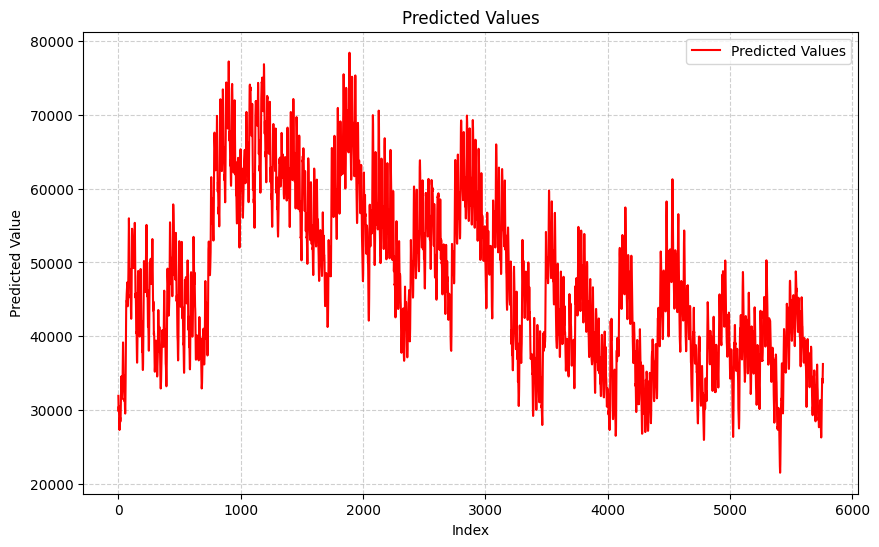

In [18]:
#On dessine les valeurs prédites
plt.figure(figsize=(10, 6))  # Taille de la figure
plt.plot(result['Predicted'], label='Predicted Values', color='red')
plt.title('Predicted Values')
plt.xlabel('Index')
plt.ylabel('Predicted Value')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Afficher le graphique
plt.show()